This aims to be a tutorial for beginners that already introduces cocepts that until
now are mostly used by experienced users.

We want to model a group of buildings, each with demands for electricity and space heating. 
Each has its individual heat pump and is connected to the electricity grid.
Some of the buildings have extra features, such as demand for domestic hot water or a PV system.

First, we define an energy system.

                     input/output  b_el_grid   b_el    b_heat    b_DHW
                         |             |        |         |        |
       Grid Connection   |------------>|        |         |        |
         (Source)        |             |        |         |        |
                         |             |        |         |        |
       Demand for both   |<-------------------------------|        |
       Houses(Sink)      |             |        |         |        |
                         |             |        |         |        |
       Heat Pump for both|<-------------------------------|        |
       Houses(Converter) |--------------------->|         |        |
                         |             |        |         |        |
       DHW_demand(Sink)  |<----------------------------------------|
       Only for House 1  |             |        |         |        |
                         |             |        |         |        |
       Flow_heater       |<----------------------------------------|
       (Converter) Only  |--------------------->|         |        |
       for House 1       |             |        |         |        |
                         |             |        |         |        |
       PV(Source)        |--------------------->|         |        |
       Only for house 2  |                      |         |        |


Note that solph expects time points for its index.
Time intervals are defined between the points in time.
If your points in time have a regular pattern, you can (at your option) infer the last interval.
Typically, it's better to explicitly give N+1 points in time to define N time intervals.

In [2]:
import datetime
from oemof import solph
import numpy as np
import pandas as pd

In [3]:
# import datetime
# from oemof import solph

n_time_points = 25

first_timepoint = datetime.datetime(2023,2,1,6)
time_index = solph.create_time_index(2024, number=n_time_points, start=first_timepoint)

energy_system = solph.EnergySystem(
    timeindex=time_index,
    infer_last_interval=False,
)


c:\Users\vach_pa\.conda\envs\oemof\lib\site-packages\oemof\solph\_energy_system.py:305: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(start, periods=number + 1, freq=f"{interval}H")


In [4]:
# import numpy as np
# import pandas as pd

# Loading dataset

temperatures = pd.read_csv(
    "input_data.csv",
    parse_dates=[0],
    index_col=0,
    date_format="%Y%m%d%H",
)

input_data = temperatures.reindex(time_index)

locations = ["house_1", "house_2"]
heat_up_to = [12, 15]
power_per_degree = [0.7, 1.1]

for location, temperature, power in zip(locations, heat_up_to, power_per_degree):
    input_data[f"heat_demand_{location}"] = np.maximum(temperature - input_data["TT_TU"], 0) * power

The energy system is modelled as a mathematcal graph.
Often, `Bus`es are used to model commodities.
These are then connected by `Converter`s and to storages.
Each of these nodes needs a unique label to be identified.
Edges are directed and identified by the Nodes they connect to.

Many users use strings as labels.
However, as energy systems become complex, keeping track of all the information can be hard.
In particular, manually managing string labels can be tedious.
Here, it comes handy that `Node`s (defined in oemof.network) accept every hashable type.

A custom string representation is advised as the defauls (including type names) can be very long.
But labels should be easy to understand.

In [5]:
from typing import NamedTuple
from enum import IntEnum

# A frozenset is an immutable set.
# Set: Every sector present only once.
# Imutable:
#    - sectors cannot be changed
#    - makes the class hashable
class Label(NamedTuple):
    location: str
    sectors: frozenset[int]
    component: str

    def __str__(self):
        return f"{self.location}/{sum(int(s) for s in self.sectors)}/{self.component}"


For the sectors, we create an Enum.
Enums are very useful to make sure, only predefined values are used.
This, e.g. prevents typos staying unnoticed.
The IntEnum in the example is defined in a way that any combination of sectors gives a unique ID.
This is a bit C-Style low-level encoding but can be useful, e.g. when saving the info to a file.

In [6]:

class Sectors(IntEnum):
    ELECTRICITY = 1
    HEAT = 2
    HYDROGEN = 4


The Label above needs a frozenset.
To freeze sets in the background, we create a factory function.

In [7]:

def label(
    location: str,
    sectors: set[int],
    component: str,
) -> Label:
    return Label(location, frozenset(sectors),component)

We now populate the energy system. It consists of several houses and a grid.
Let's start with the grid, as every house should be able to connect to it.
(Note that some of the functionality does not rely on storing information in the label.
It could be placed elsewhere. However, it is convenient to have it there, as you will see soon.)

In [8]:
location="grid"

b_el_grid = solph.Bus(label(location, {Sectors.ELECTRICITY}, "Bus"))
energy_system.add(b_el_grid)

energy_system.add(
    solph.components.Source(
        label(location, {Sectors.ELECTRICITY}, "grid_connection"),
        outputs={b_el_grid: solph.Flow(variable_costs=0.4)},
        # custom_attributes={"sectors": {Sectors.ELECTRICITY}}
    )
)


The houses start with an identical base: One Bus for electricity and one for heat.
Note that the busses are just called "Bus".

In [9]:

locations = ["house_1", "house_2"]

for number, location in enumerate(locations):
    b_el = solph.Bus(
        label(location, {Sectors.ELECTRICITY}, "Bus"),
        inputs={b_el_grid: solph.Flow()},
        outputs={b_el_grid: solph.Flow()},
    )
    b_heat = solph.Bus(label(location, {Sectors.HEAT}, "Bus"))

    energy_system.add(b_el, b_heat)

    energy_system.add(
        solph.components.Sink(
            label(location, {Sectors.HEAT}, "Demand"),
            inputs={
                b_heat: solph.Flow(nominal_value=1, fix=input_data[f"heat_demand_{location}"])
            },
        )
    )

    cop = 3
    energy_system.add(
        solph.components.Converter(
            label(location, {Sectors.ELECTRICITY, Sectors.HEAT}, "heat_pump"),
            inputs={b_el: solph.Flow()},
            outputs={b_heat: solph.Flow()},
            conversion_factors={b_el: 1 / cop},
        )
    )


Now, we can add custom features to the houses.

House 1 receives additional demand for domestic hot water (b_DWH) in just one hour.

It's not in the input data, so we create something manually.
(This is possible, but not advised. It's always good to have a time index.)

Note that we access the electricity bus using its label.
(The API is experimental, the way to do this might be changed with the next release of oemof.network.)

In [10]:
location = "house_1"

b_dhw = solph.Bus(label(location, {Sectors.HEAT}, "Bus_DHW"))
energy_system.add(b_dhw)

energy_system.add(
    solph.components.Sink(
        label(location, {Sectors.HEAT}, "DHW_Demand"),
        inputs={b_dhw: solph.Flow(
            nominal_value=1,
            fix=6*[0] + 1*[12] + 18*[0],
        )},
    )
)

b_el = energy_system.node[label(location, {Sectors.ELECTRICITY}, "Bus")]
energy_system.add(
    solph.components.Converter(
        label(location, {Sectors.ELECTRICITY, Sectors.HEAT}, "flow_heater"),
        inputs={b_el: solph.Flow()},
        outputs={b_dhw: solph.Flow()},
    )
)

c:\Users\vach_pa\.conda\envs\oemof\lib\site-packages\oemof\network\energy_system.py:205: ExperimentalFeatureWarning: The API to access nodes by label is experimental and might change without prior notice.
  warnings.warn(msg, debugging.ExperimentalFeatureWarning)


House 2 gets a PV system.
There are two common ways to model it:
* Seing PV generation as fix Flow, making an excess `Sink` obligatory.
* Setting the PV series as the maximum possible Flow.

In [11]:
energy_system.add(
    solph.components.Source(
        label("house_2", {Sectors.ELECTRICITY}, "PV"),
        outputs={
            energy_system.node[label("house_2", {Sectors.ELECTRICITY}, "Bus")]:
                solph.Flow(nominal_value=50, max=input_data["PV"]),
        },
    )
)

c:\Users\vach_pa\.conda\envs\oemof\lib\site-packages\oemof\solph\flows\_flow.py:268: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if self.nominal_value is not None and not math.isfinite(self.max[0]):


Before we optimise the problem, we visually check the graph.

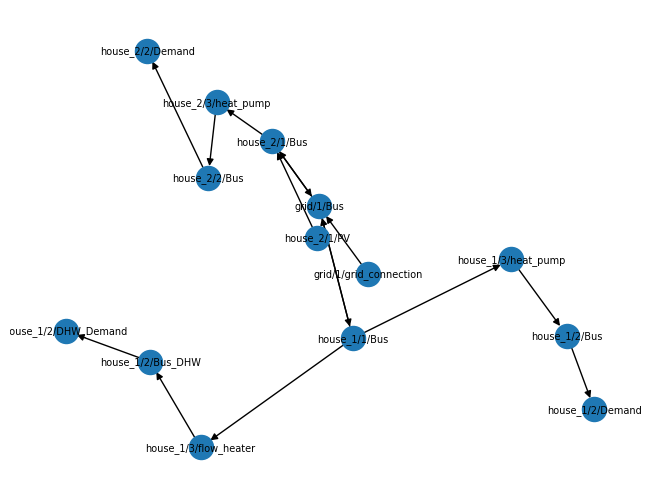

In [12]:
import networkx as nx
from oemof.network.graph import create_nx_graph

graph = create_nx_graph(energy_system)

nx.draw(graph, with_labels=True, font_size=7)

Optimizing the Energy System model

In [13]:
model = solph.Model(energy_system)
model.solve(solver="cbc", solve_kwargs={"tee": False})
results = solph.processing.results(model)

c:\Users\vach_pa\.conda\envs\oemof\lib\site-packages\oemof\solph\_models.py:497: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if self.flows[o, i].fix[self.TIMESTEPS.at(1)] is not None:
c:\Users\vach_pa\.conda\envs\oemof\lib\site-packages\oemof\solph\_models.py:500: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.flows[o, i].fix[t]
c:\Users\vach_pa\.conda\envs\oemof\lib\site-packages\oemof\solph\_models.py:500: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

After Energy Optimization, we can visualise HEAT data by combination of flow_to_heat dataframe with heat_demand dataframe

In [16]:
# import pandas as pd

flows_to_heat = pd.DataFrame({
    f"{k[0].label.location}-{k[0].label.component}": v["sequences"]["flow"]
    for k, v in results.items()
    if (
        isinstance(k[1], solph.Bus)
        and Sectors.HEAT in k[1].label.sectors
    )
})

heat_demand = pd.DataFrame({
    f"{k[0].label.location}-{k[1].label.component}": v["sequences"]["flow"]
    for k, v in results.items()
    if isinstance(k[1], solph.components.Sink)
})

heat_flows = pd.concat(
    [flows_to_heat, heat_demand],
    axis=1,
)

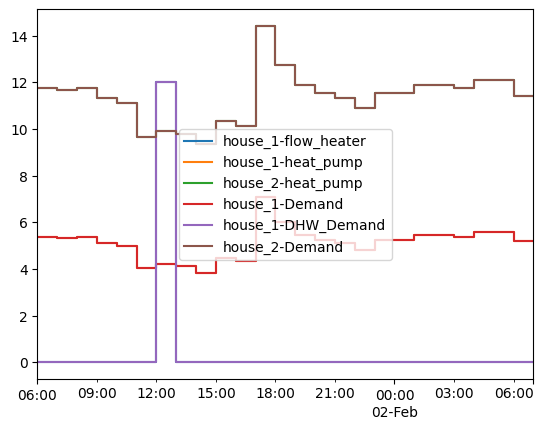

In [20]:
import matplotlib.pyplot as plt

heat_flows.plot(drawstyle="steps-post")

plt.show()

Additionally, We can also visualise ELECTRICITY data by Grid source electricity dataframe and PV source house 2 dataframe

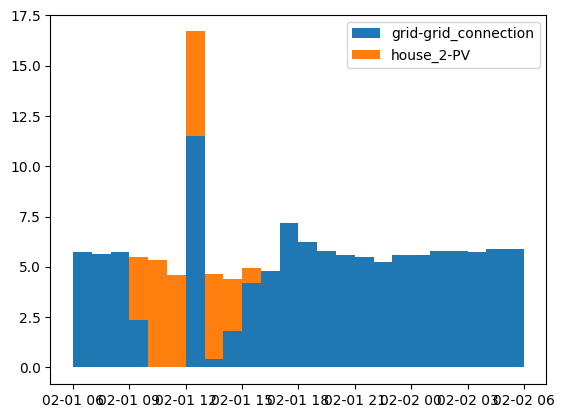

In [21]:
electricity_sources = pd.DataFrame({
    f"{k[0].label.location}-{k[0].label.component}": v["sequences"]["flow"]
    for k, v in results.items()
    if isinstance(k[0], solph.components.Source)
    and Sectors.ELECTRICITY in k[0].label.sectors
})

previous_sources = np.zeros(len(electricity_sources))

for source in electricity_sources:
    current_source = previous_sources + electricity_sources[source]
    plt.fill_between(
        electricity_sources.index,
        previous_sources,
        current_source,
        label=source,
        step="post",
    )
    previous_sources = current_source

plt.legend()
plt.show()